# Image slicing 

Generate field images from the X and Y locations existing in each frame within the tracking data. 

## Import Packages

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

## Import Data

Import the play and tracking data

In [14]:
week1=pd.read_csv('../data/week1.csv')
plays=pd.read_csv('../data/plays.csv')

## Inspect Data

Look at first 5 rows of each dataset.

In [15]:
display(week1.head())
display(plays.head())

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,week
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,1
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,1
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,1
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


Inspect the tracking data to see the distribution of x and y values.

In [4]:
week1.describe()

,x,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId,gameId,playId
count,986022.000000,986022.000000,986022.000000,986022.000000,986022.000000,919109.000000,919109.000000,9.191090e+05,919109.000000,986022.000000,9.860220e+05,986022.000000
mean,58.975056,26.795439,3.187303,2.012526,0.323366,179.545196,181.238304,2.366598e+06,37.763714,35.450674,2.018091e+09,2268.306314
std,24.935961,11.204589,2.843484,1.689410,0.307017,100.706586,102.965112,6.193264e+05,24.977470,23.654286,9.381592e+01,1280.426499
min,-5.980000,-11.740000,0.000000,0.000000,0.000000,0.000000,0.000000,3.060000e+02,1.000000,1.000000,2.018091e+09,58.000000
25%,39.980000,19.000000,0.850000,0.740000,0.090000,89.880000,91.520000,2.533040e+06,20.000000,17.000000,2.018091e+09,1199.000000
50%,59.100000,26.830000,2.790000,1.750000,0.280000,177.430000,181.410000,2.552255e+06,29.000000,33.000000,2.018091e+09,2297.000000
75%,78.190000,34.710000,4.960000,2.940000,0.500000,269.840000,271.350000,2.556480e+06,53.000000,50.000000,2.018091e+09,3315.000000
max,128.380000,62.750000,27.370000,58.330000,7.120000,360.000000,360.000000,2.561485e+06,99.000000,172.000000,2.018091e+09,5511.000000


Even though the summary of the NFL data says that the max x value is 120 and max y is 53.3, we are seeing values above this. Let's use the max of each of these values later when defining our blank field for the dimensions. 

## Process Data

Multiply each point by 10 so we can then transform them into integers and keep a reasonable amount of specificity.

In [5]:
week1.loc[:,"x"] = week1["x"] * 10
week1.loc[:,"y"] = week1["y"] * 10
week1.loc[:,"x"] = week1["x"].astype("int")
week1.loc[:,"y"] = week1["y"].astype("int")

## Inspect Sample Play

Take a look at one play.

In [6]:
sample_play = week1[week1["playId"] == plays.loc[0,"playId"]]
sample_play

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,917,266,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,888,364,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,913,441,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,863,220,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,907,361,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,2018-09-07T01:07:20.400Z,767,524,3.86,3.56,0.39,55.22,22.42,None,2555383.0,Jalen Mills,31.0,CB,59,home,2018090600,75,left,NaN
822,2018-09-07T01:07:20.400Z,774,95,3.44,5.45,0.38,96.53,182.50,None,2555415.0,Austin Hooper,81.0,TE,59,away,2018090600,75,left,OUT
823,2018-09-07T01:07:20.400Z,780,385,5.47,3.04,0.56,336.15,338.39,None,2558175.0,Nate Gerry,47.0,LB,59,home,2018090600,75,left,NaN
824,2018-09-07T01:07:20.400Z,843,57,3.78,4.31,0.38,39.11,246.16,None,2559033.0,Ricky Ortiz,30.0,FB,59,away,2018090600,75,left,FLAT


## Inspect Sample Frame

Take a look at one frame within a play.

In [7]:
sample_frame_number = 1
sample_frame = sample_play[sample_play["frameId"] == sample_frame_number]
sample_frame

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,917,266,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,888,364,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,913,441,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,863,220,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,907,361,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
5,2018-09-07T01:07:14.599Z,736,287,0.03,0.02,0.01,103.05,219.41,None,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN
6,2018-09-07T01:07:14.599Z,982,266,0.01,0.01,0.00,265.88,194.51,None,2543583.0,Devonta Freeman,24.0,RB,1,away,2018090600,75,left,NaN
7,2018-09-07T01:07:14.599Z,864,311,0.09,0.03,0.04,95.90,33.36,None,2552315.0,Jordan Hicks,58.0,MLB,1,home,2018090600,75,left,NaN
8,2018-09-07T01:07:14.599Z,826,205,0.03,0.07,0.01,81.14,174.57,None,2552689.0,Ronald Darby,21.0,CB,1,home,2018090600,75,left,NaN
9,2018-09-07T01:07:14.599Z,840,434,0.14,0.05,0.01,108.23,110.32,None,2555383.0,Jalen Mills,31.0,CB,1,home,2018090600,75,left,NaN


## Generate a Field For The Sample Frame

Start by generating a blank field using the max x and y values as the dimensions.

In [8]:
max_x = week1["x"].max()
max_y = week1["y"].max()
field=np.zeros((max_x,max_y))

Place 1s on positions within the field where players are.

In [9]:
for row in sample_frame.loc[:,["x","y"]].iterrows():
    field[row[1].x, row[1].y] = 1

## Display Field

Display field as image where black dots are player locations.

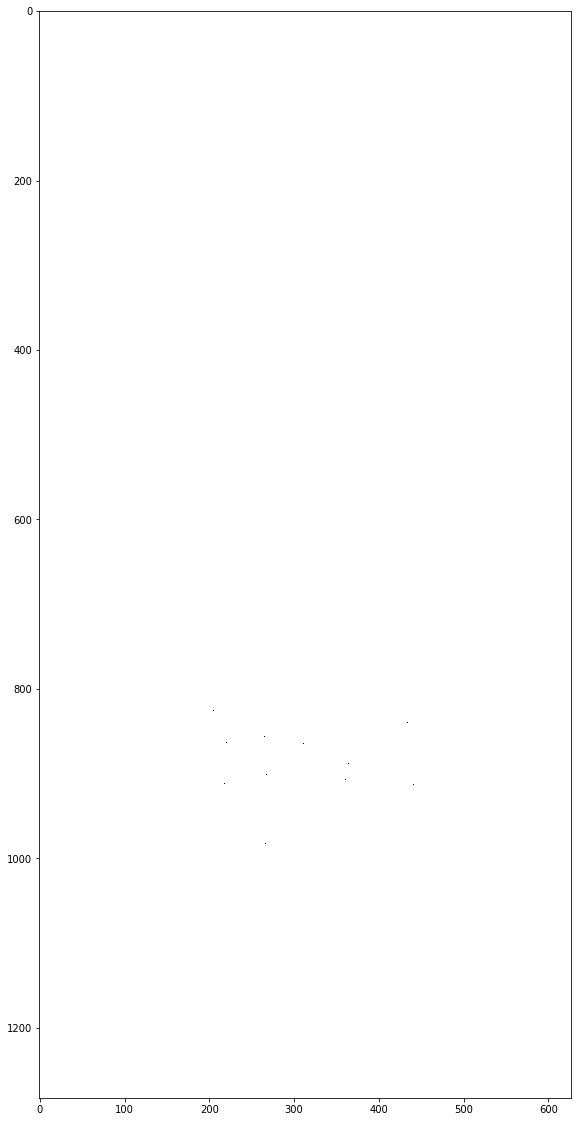

In [10]:
def display_field(field):
    fig = plt.figure(figsize=(40,20))
    plt.imshow(field, interpolation='nearest', cmap='Greys')
    plt.savefig("../images/example_field.png")
    plt.show()
display_field(field)

## Generate Fields For Entire Dataset

Begins work to generate fields for entire dataset. 

Here we split out the columns we want to use and group the data to the frame level.

In [11]:
tracking_data_cols = ["gameId", "playId", "frameId", "x", "y", "time"]
tracking_data = week1[tracking_data_cols]
tracking_data = tracking_data.groupby(["gameId","playId","frameId"]).agg(list)
tracking_data["time"] = tracking_data["time"].apply(lambda x: min(x))
tracking_data

x  \
gameId     playId frameId                                                      
2018090600 75     1        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  2        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  3        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  4        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  5        [917, 889, 913, 863, 907, 736, 982, 865, 826, ...   
...                                                                      ...   
2018091001 4192   61       [208, 318, 371, 296, 459, 245, 469, 333, 318, ...   
                  62       [207, 316, 371, 294, 455, 247, 468, 331, 317, ...   
                  63       [207, 313, 371, 293, 452, 248, 467, 329, 317, ...   
                  64       [206, 310, 370, 292, 448, 249, 466, 326, 316, ...   
                  65       [206, 308, 369, 290, 444, 250, 464, 324, 316, ...   

                                                                           y  \
gameId     playId frameId                                                      
2018090600 75     1        [266, 364, 441, 220, 361, 287, 266, 311, 205, ...   
                  2        [266, 364, 441, 220, 361, 287, 266, 311, 205, ...   
                  3        [266, 364, 441, 220, 361, 286, 266, 311, 205, ...   
                  4        [266, 364, 441, 220, 361, 286, 266, 310, 205, ...   
                  5        [266, 364, 441, 220, 361, 286, 266, 310, 205, ...   
...                                                                      ...   
2018091001 4192   61       [51, 444, 445, 260, 297, 347, 306, 373, 262, 1...   
                  62       [51, 444, 445, 264, 297, 351, 306, 376, 264, 1...   
                  63       [51, 444, 444, 269, 298, 356, 306, 379, 267, 1...   
                  64       [51, 444, 444, 273, 298, 361, 307, 382, 269, 1...   
                  65       [52, 444, 443, 277, 299, 365, 307, 385, 272, 2...   

                                               time  
gameId     playId frameId                            
2018090600 75     1        2018-09-07T01:07:14.599Z  
                  2        2018-09-07T01:07:14.700Z  
                  3        2018-09-07T01:07:14.799Z  
                  4        2018-09-07T01:07:14.900Z  
                  5        2018-09-07T01:07:15.000Z  
...                                             ...  
2018091001 4192   61       2018-09-11T05:29:39.500Z  
                  62       2018-09-11T05:29:39.599Z  
                  63       2018-09-11T05:29:39.700Z  
                  64       2018-09-11T05:29:39.799Z  
                  65       2018-09-11T05:29:39.900Z  

[66913 rows x 3 columns]

## Generate Field Function

Define a function to generate a field given a row from the grouped dataset and apply it to each row in the grouped dataset.

In [12]:
def generate_field(row):
    field = np.zeros((max_x,max_y)) 
    for idx, x in enumerate(row["x"]):
        y = row["y"][idx]
        try:
            field[x-1][y-1] = 1
        except Exception as e:
            print(e)
            print(row)
            print(f"X: {x} | Y: {y}")
    return field       

tracking_data["field"] = tracking_data.apply(generate_field, axis=1)
tracking_data

x  \
gameId     playId frameId                                                      
2018090600 75     1        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  2        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  3        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  4        [917, 888, 913, 863, 907, 736, 982, 864, 826, ...   
                  5        [917, 889, 913, 863, 907, 736, 982, 865, 826, ...   
...                                                                      ...   
2018091001 4192   61       [208, 318, 371, 296, 459, 245, 469, 333, 318, ...   
                  62       [207, 316, 371, 294, 455, 247, 468, 331, 317, ...   
                  63       [207, 313, 371, 293, 452, 248, 467, 329, 317, ...   
                  64       [206, 310, 370, 292, 448, 249, 466, 326, 316, ...   
                  65       [206, 308, 369, 290, 444, 250, 464, 324, 316, ...   

                                                                           y  \
gameId     playId frameId                                                      
2018090600 75     1        [266, 364, 441, 220, 361, 287, 266, 311, 205, ...   
                  2        [266, 364, 441, 220, 361, 287, 266, 311, 205, ...   
                  3        [266, 364, 441, 220, 361, 286, 266, 311, 205, ...   
                  4        [266, 364, 441, 220, 361, 286, 266, 310, 205, ...   
                  5        [266, 364, 441, 220, 361, 286, 266, 310, 205, ...   
...                                                                      ...   
2018091001 4192   61       [51, 444, 445, 260, 297, 347, 306, 373, 262, 1...   
                  62       [51, 444, 445, 264, 297, 351, 306, 376, 264, 1...   
                  63       [51, 444, 444, 269, 298, 356, 306, 379, 267, 1...   
                  64       [51, 444, 444, 273, 298, 361, 307, 382, 269, 1...   
                  65       [52, 444, 443, 277, 299, 365, 307, 385, 272, 2...   

                                               time  \
gameId     playId frameId                             
2018090600 75     1        2018-09-07T01:07:14.599Z   
                  2        2018-09-07T01:07:14.700Z   
                  3        2018-09-07T01:07:14.799Z   
                  4        2018-09-07T01:07:14.900Z   
                  5        2018-09-07T01:07:15.000Z   
...                                             ...   
2018091001 4192   61       2018-09-11T05:29:39.500Z   
                  62       2018-09-11T05:29:39.599Z   
                  63       2018-09-11T05:29:39.700Z   
                  64       2018-09-11T05:29:39.799Z   
                  65       2018-09-11T05:29:39.900Z   

                                                                       field  
gameId     playId frameId                                                     
2018090600 75     1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  2        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  3        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  4        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  5        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
...                                                                      ...  
2018091001 4192   61       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  62       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  63       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  64       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
                  65       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[66913 rows x 4 columns]

## Inspect Random Field

Take a look at a random field to see if everything looks correct.

Game ID: 2018090905 | Play ID: 783 | Frame ID: 46


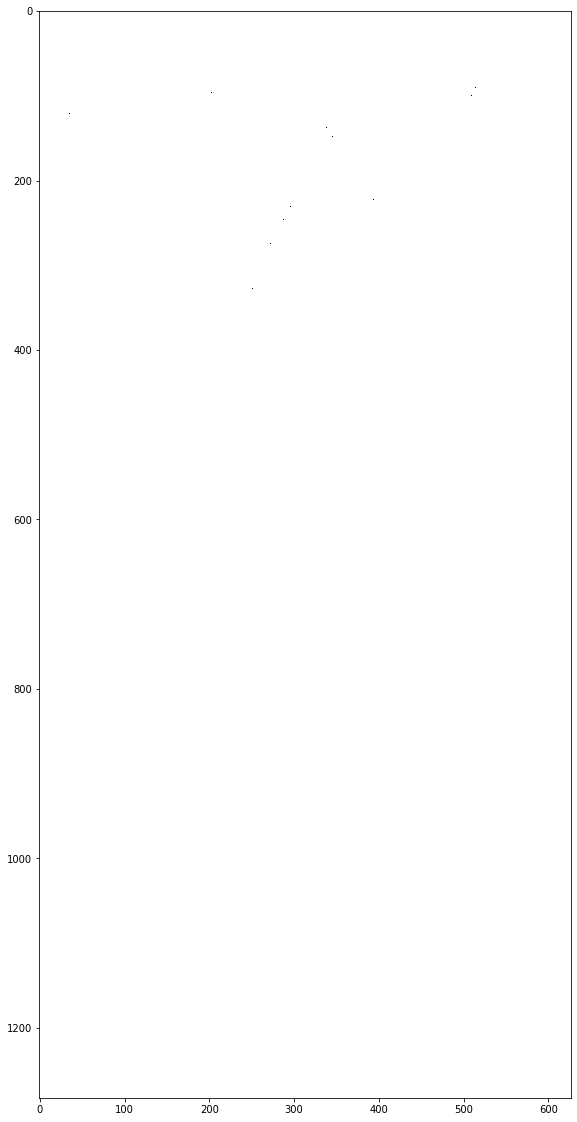

In [13]:
sample_frame = tracking_data.sample(1)
random_frame_info = sample_frame.index[0]
print(f"Game ID: {random_frame_info[0]} | Play ID: {random_frame_info[1]} | Frame ID: {random_frame_info[2]}")
field = sample_frame.field.values[0]
display_field(field)